In [1]:
import numpy as np

# 2D
mu1 = [1.00, 1.00]
mu2 = [-1.00, 1.00]
mu3 = [-1.00, -1.00]
mu4 = [1.00, -1.00]

cov1 = [[0.4, 0],
[0, 0.4]]
cov2 = cov1
cov3 = cov1
cov4 = cov1

rng = np.random.RandomState(2032)

prevalences = np.array([0.25, 0.25, 0.25, 0.25])

x_train = np.vstack((rng.multivariate_normal(mu1, cov1, int(prevalences[0] * 1000)),
rng.multivariate_normal(mu2, cov2, int(prevalences[1] * 1000)),
rng.multivariate_normal(mu3, cov3, int(prevalences[2] * 1000)),
rng.multivariate_normal(mu4, cov4, int(prevalences[3] * 1000))))

y_train=[0]*int(1000*prevalences[0])+[1]*int(1000*prevalences[1])+[2]*int(1000*prevalences[2])+[3]*int(1000*prevalences[3])

x_test = np.vstack((rng.multivariate_normal(mu1, cov1, int(prevalences[0] * 1000)),
rng.multivariate_normal(mu2, cov2, int(prevalences[1] * 1000)),
rng.multivariate_normal(mu3, cov3, int(prevalences[2] * 1000)),
rng.multivariate_normal(mu4, cov4, int(prevalences[3] * 1000))))

y_test=[0]*int(1000*prevalences[0])+[1]*int(1000*prevalences[1])+[2]*int(1000*prevalences[2])+[3]*int(1000*prevalences[3])



In [5]:
#Train traditional quantifiers
import quapy as qp
from quapy.protocol import APP
from sklearn.linear_model import LogisticRegression
from quapy.method.aggregative import EMQ
from sklearn.calibration import CalibratedClassifierCV

data = qp.data.LabelledCollection(x_train, y_train)
modelEMQ = qp.model_selection.GridSearchQ(
    #model=EMQ(CalibratedClassifierCV(LogisticRegression(max_iter=1000),n_jobs=-1)),
    model=EMQ(LogisticRegression(max_iter=1000)),
    param_grid={'C': np.logspace(-4,5,10), 'class_weight': ['balanced', None]},
    error='mae',
    n_jobs=14,
    protocol=APP(data=data,sample_size=100),
    refit=True,  # retrain on the whole labelled set
    verbose=True  # show information as the process goes on
).fit(data)

[GridSearchQ]: hyperparams={'C': 10.0, 'class_weight': None}	 got mae score 0.01374 [took 11.0876s]
[GridSearchQ]: hyperparams={'C': 100.0, 'class_weight': None}	 got mae score 0.01370 [took 12.7827s]
[GridSearchQ]: hyperparams={'C': 1.0, 'class_weight': None}	 got mae score 0.01404 [took 14.3091s]
[GridSearchQ]: hyperparams={'C': 100.0, 'class_weight': 'balanced'}	 got mae score 0.01372 [took 16.4808s]
[GridSearchQ]: hyperparams={'C': 10.0, 'class_weight': 'balanced'}	 got mae score 0.01365 [took 17.5192s]
[GridSearchQ]: hyperparams={'C': 1.0, 'class_weight': 'balanced'}	 got mae score 0.01403 [took 17.5827s]
[GridSearchQ]: hyperparams={'C': 0.1, 'class_weight': None}	 got mae score 0.02000 [took 18.6437s]
[GridSearchQ]: hyperparams={'C': 0.1, 'class_weight': 'balanced'}	 got mae score 0.01983 [took 18.7977s]
[GridSearchQ]: hyperparams={'C': 0.01, 'class_weight': None}	 got mae score 0.05701 [took 23.0600s]
[GridSearchQ]: hyperparams={'C': 1000.0, 'class_weight': None}	 got mae score 

In [52]:
#Config
ind_points = 4
epochs = 200
n_bins = 8


Using training set as validation set for early stopping
Using device cpu
[test_synthetic] Starting epoch 0...
[test_synthetic] Elapsed training time:0.53s
[test_synthetic] [Epoch=000] Train Loss=[QuantLoss=0.15550]. Val loss = [QuantLoss=0.15550][saved best model in this epoch]
[test_synthetic] Starting epoch 1...
[test_synthetic] Elapsed training time:0.49s
[test_synthetic] [Epoch=001] Train Loss=[QuantLoss=0.15499]. Val loss = [QuantLoss=0.15499][saved best model in this epoch]
[test_synthetic] Starting epoch 2...
[test_synthetic] Elapsed training time:0.72s
[test_synthetic] [Epoch=002] Train Loss=[QuantLoss=0.16140]. Val loss = [QuantLoss=0.16140]
[test_synthetic] Starting epoch 3...
[test_synthetic] Elapsed training time:0.49s
[test_synthetic] [Epoch=003] Train Loss=[QuantLoss=0.14572]. Val loss = [QuantLoss=0.14572][saved best model in this epoch]
[test_synthetic] Starting epoch 4...
[test_synthetic] Elapsed training time:0.49s
[test_synthetic] [Epoch=004] Train Loss=[QuantLoss=0.

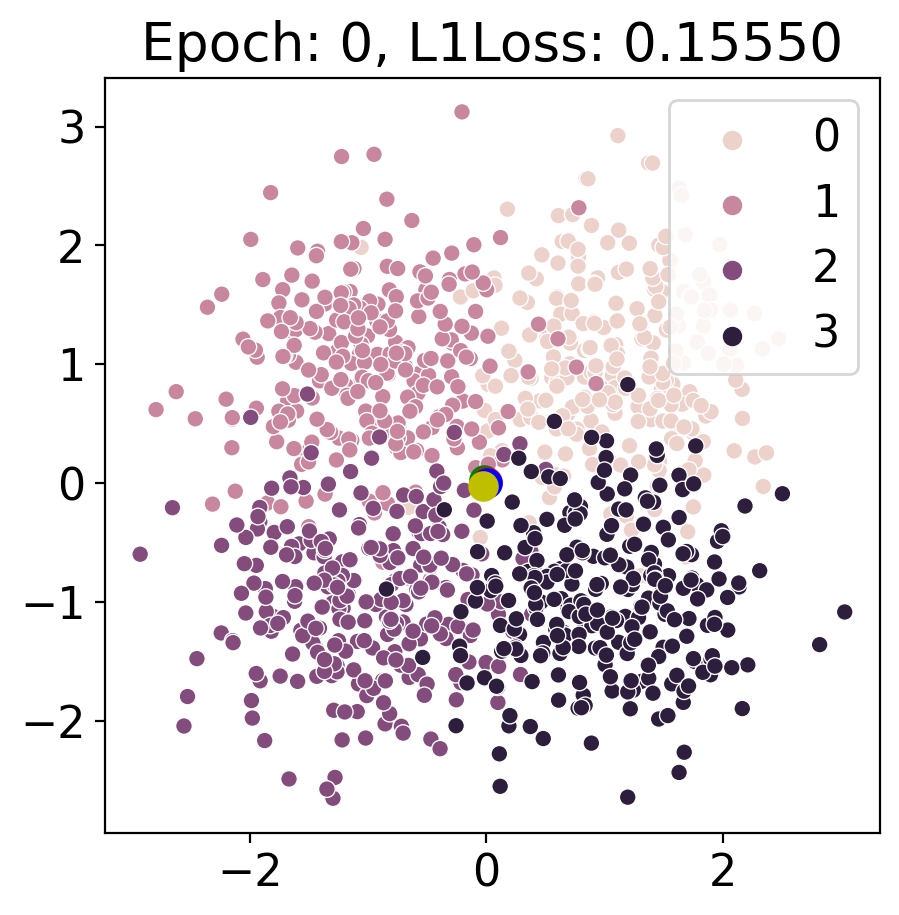

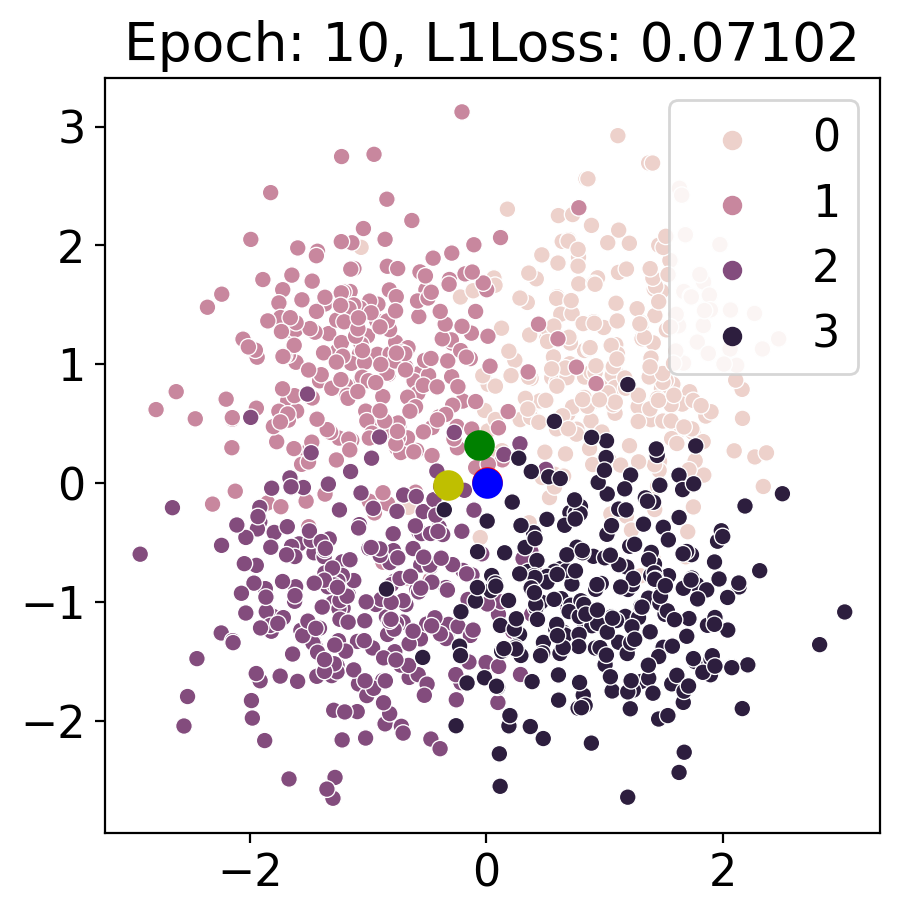

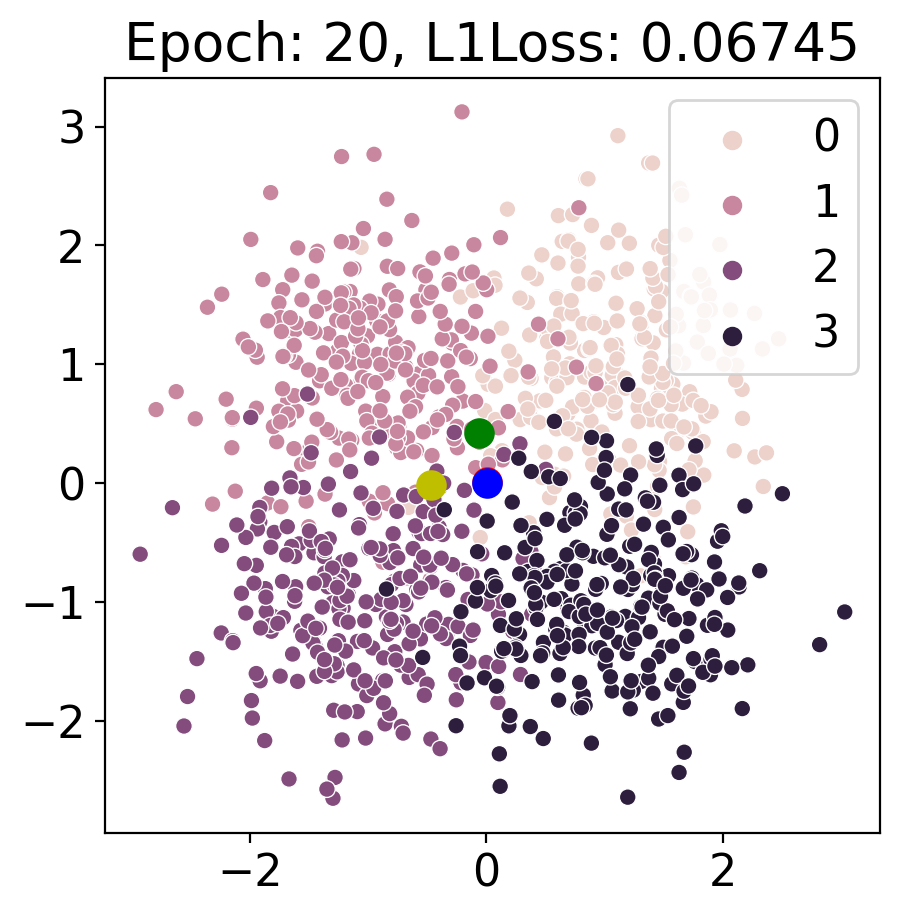

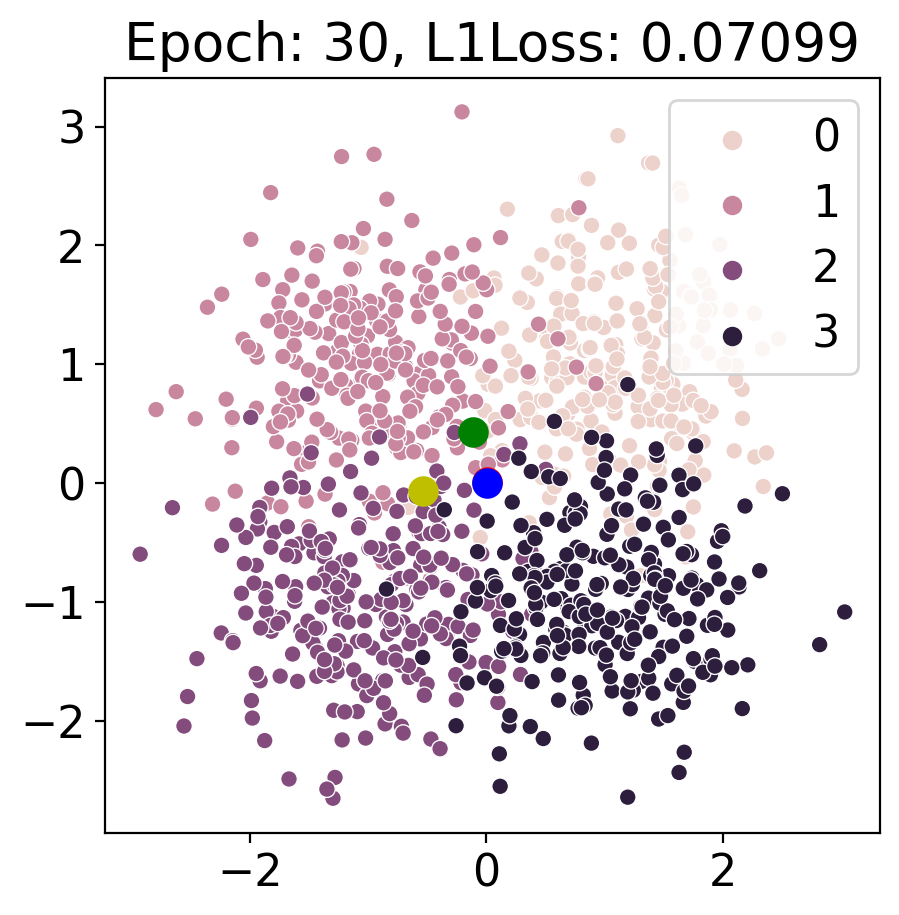

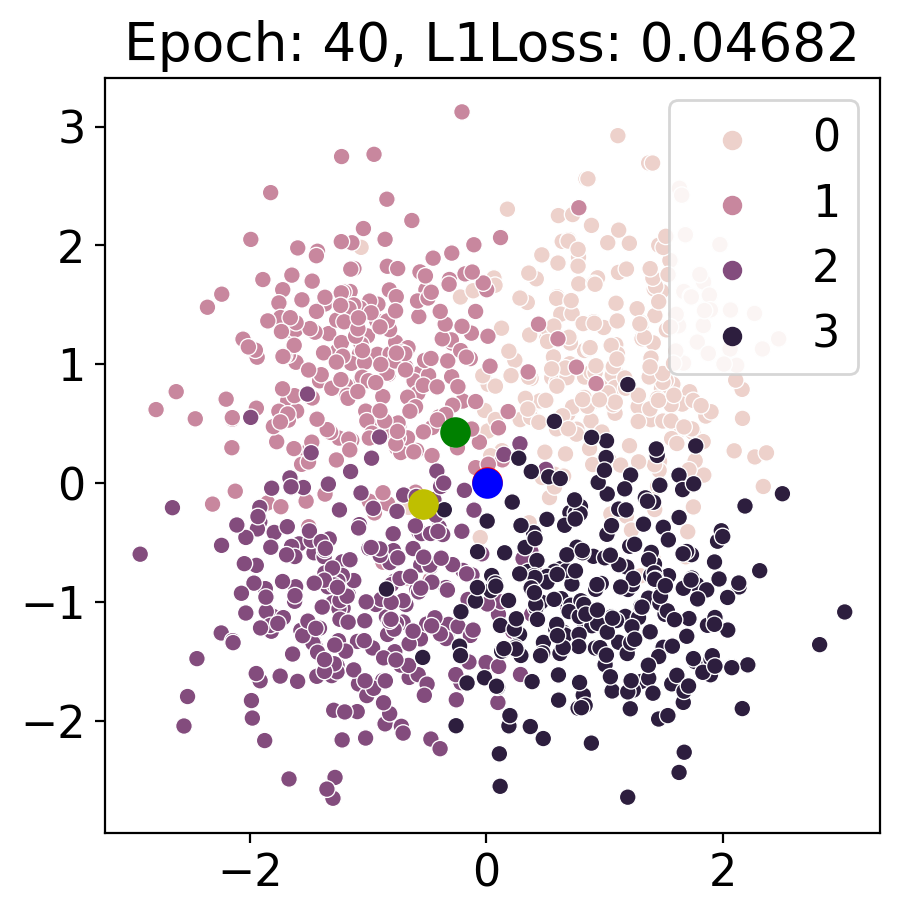

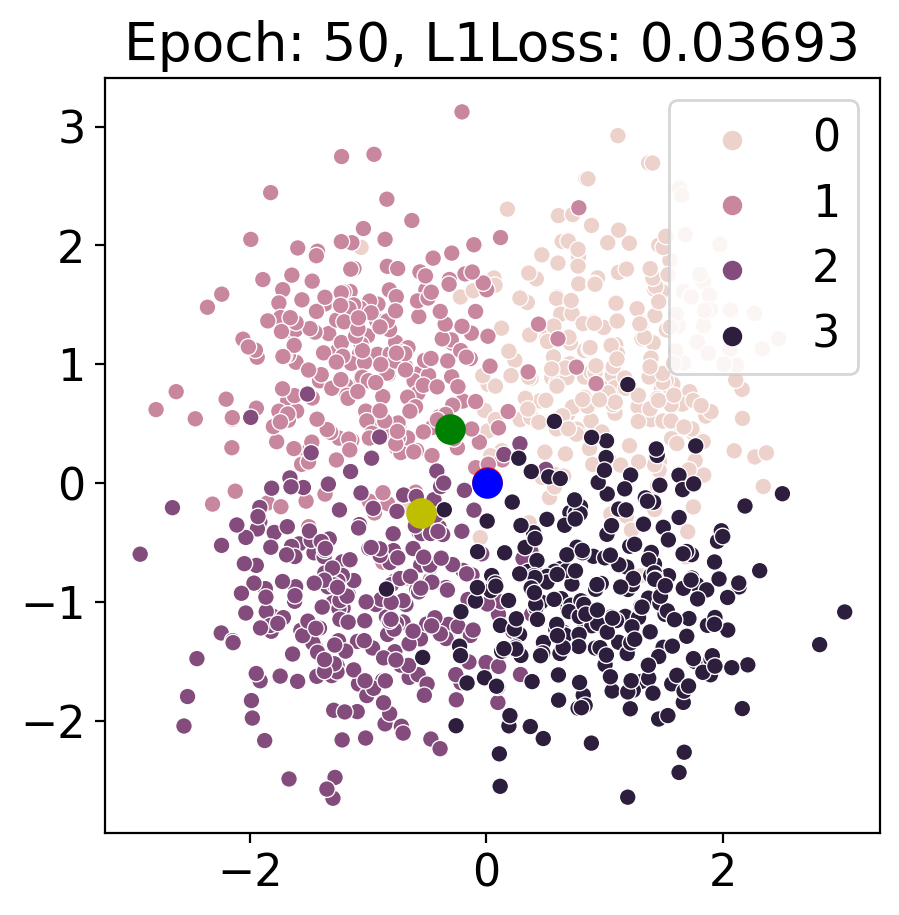

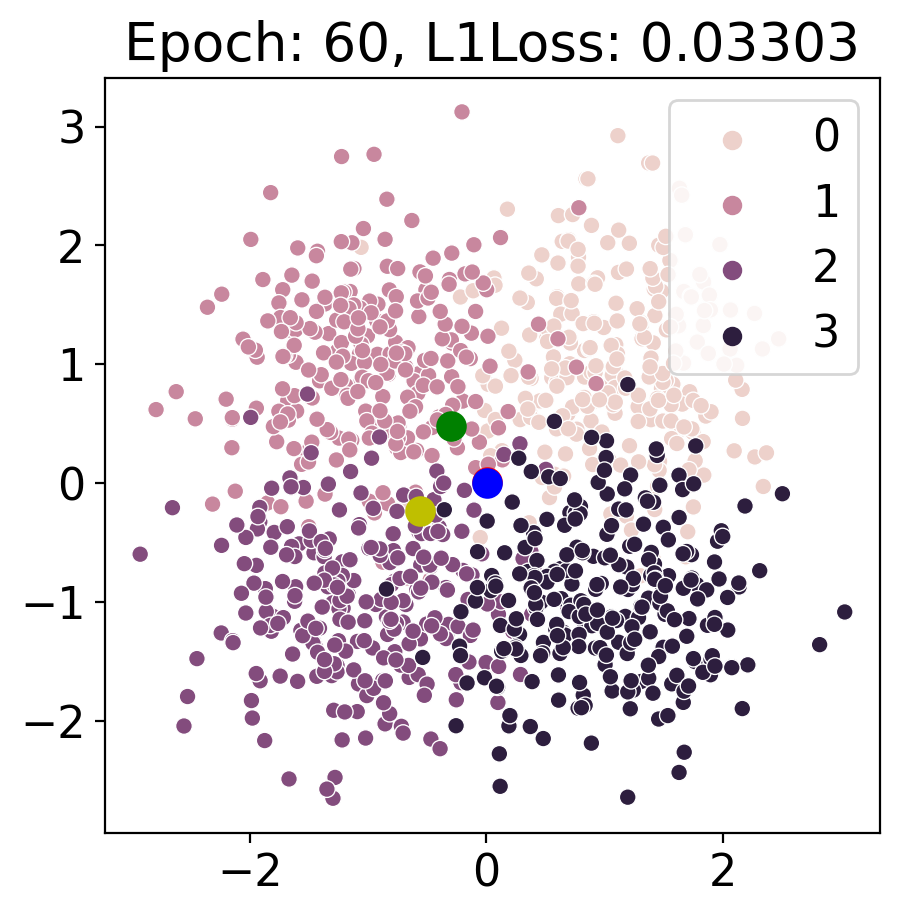

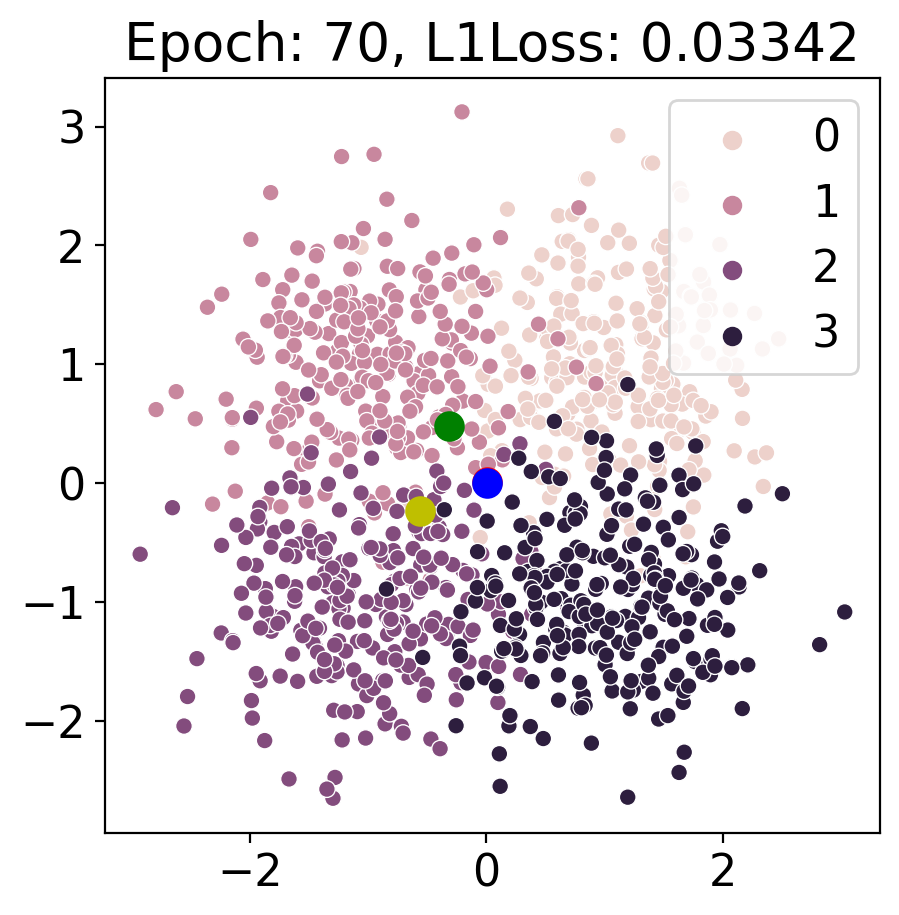

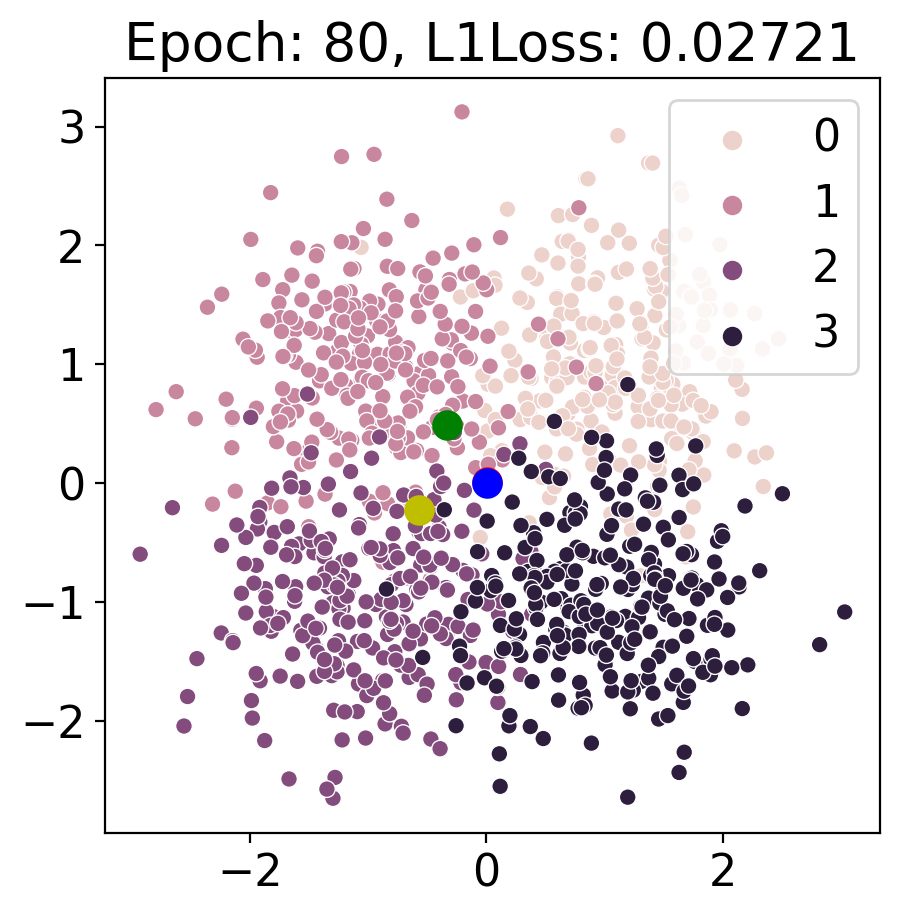

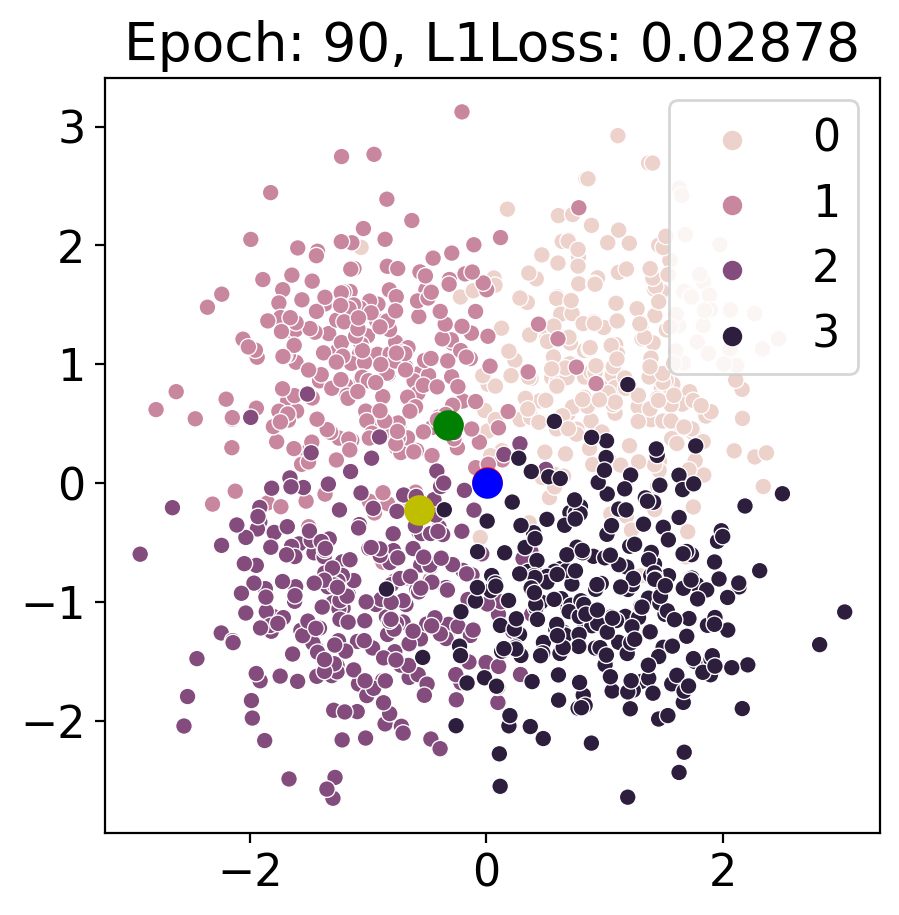

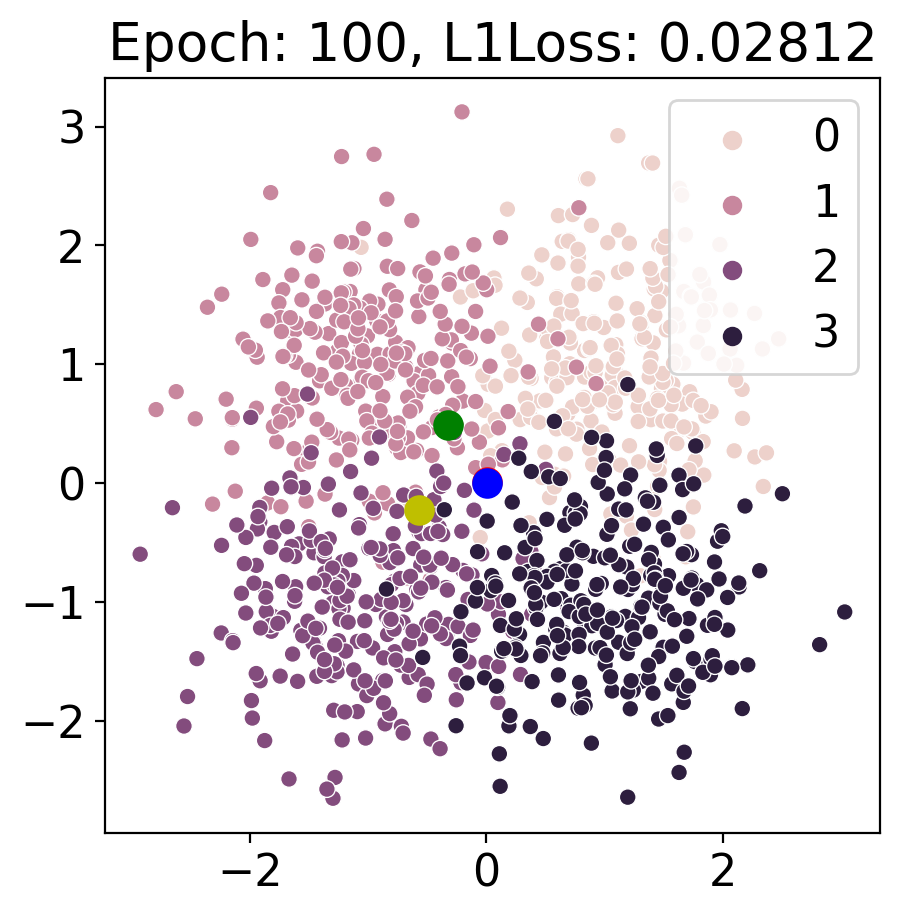

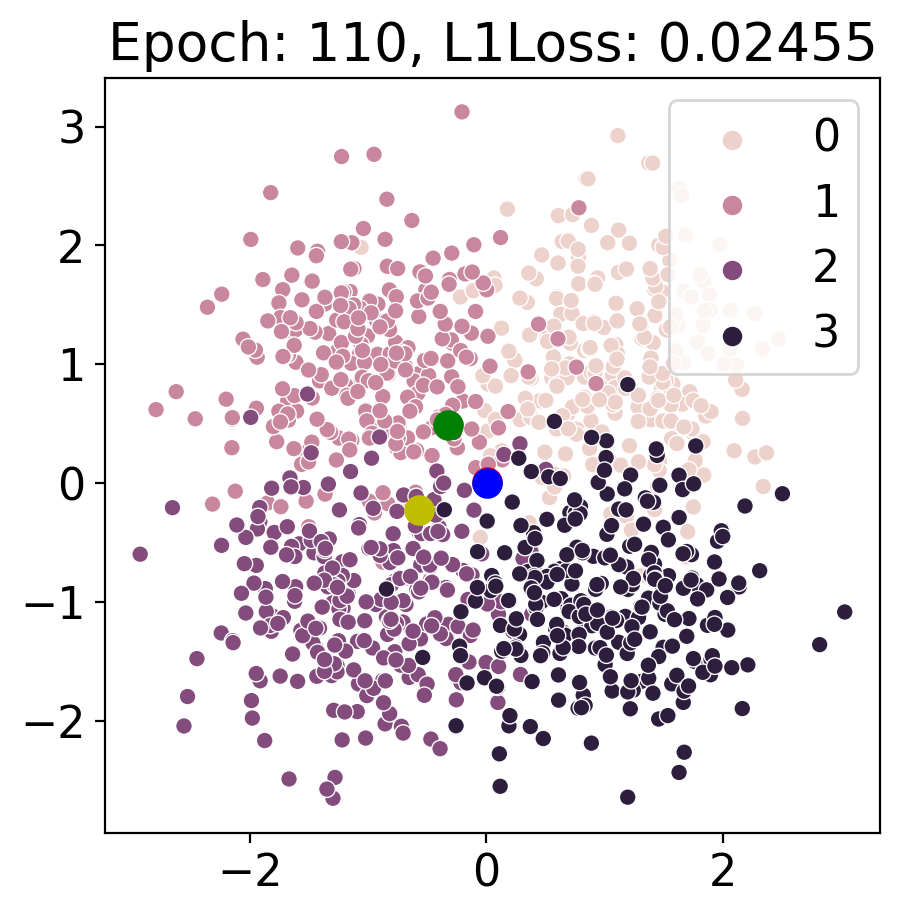

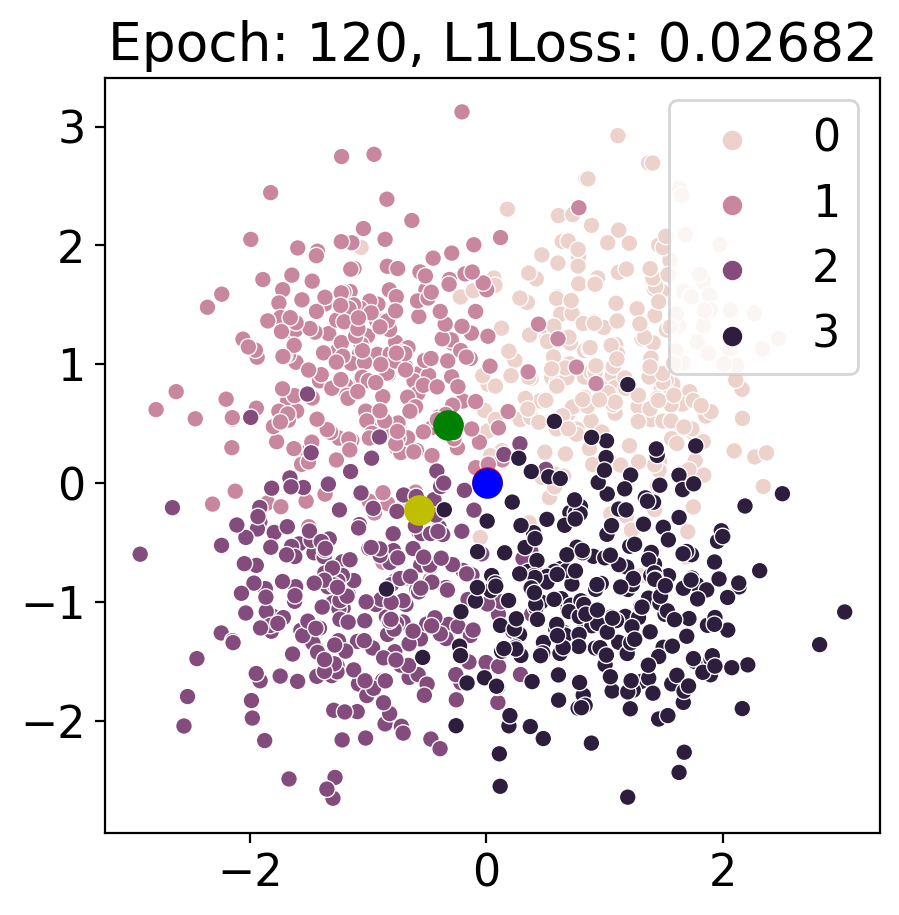

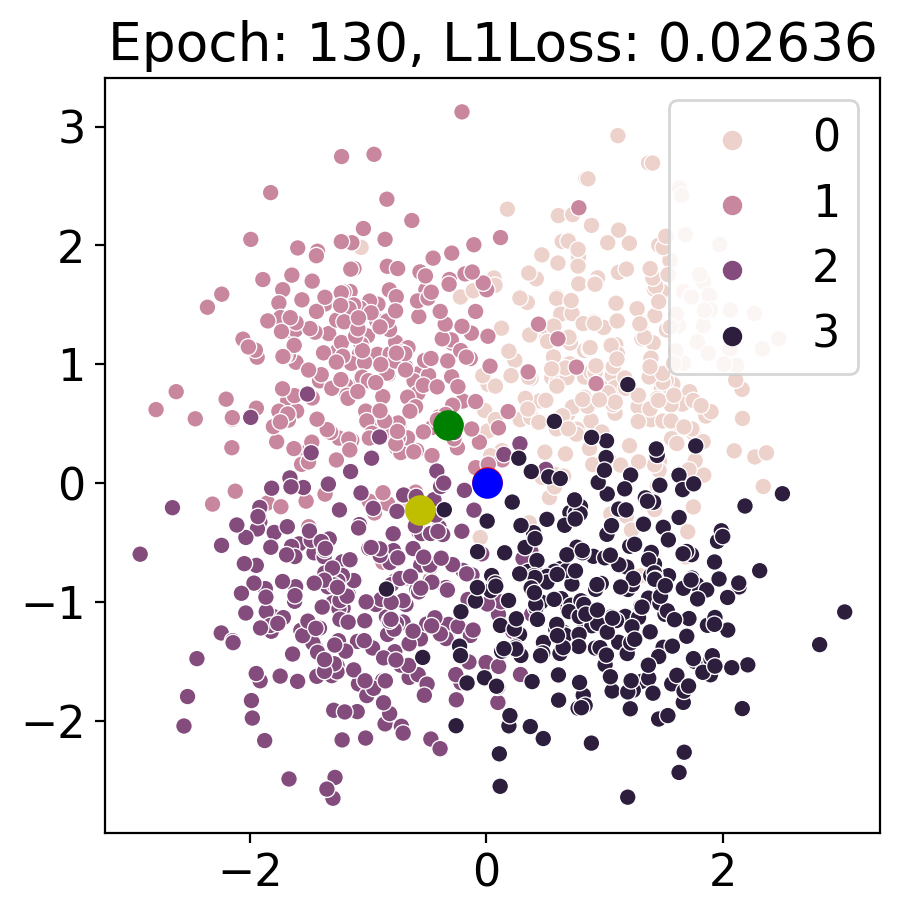

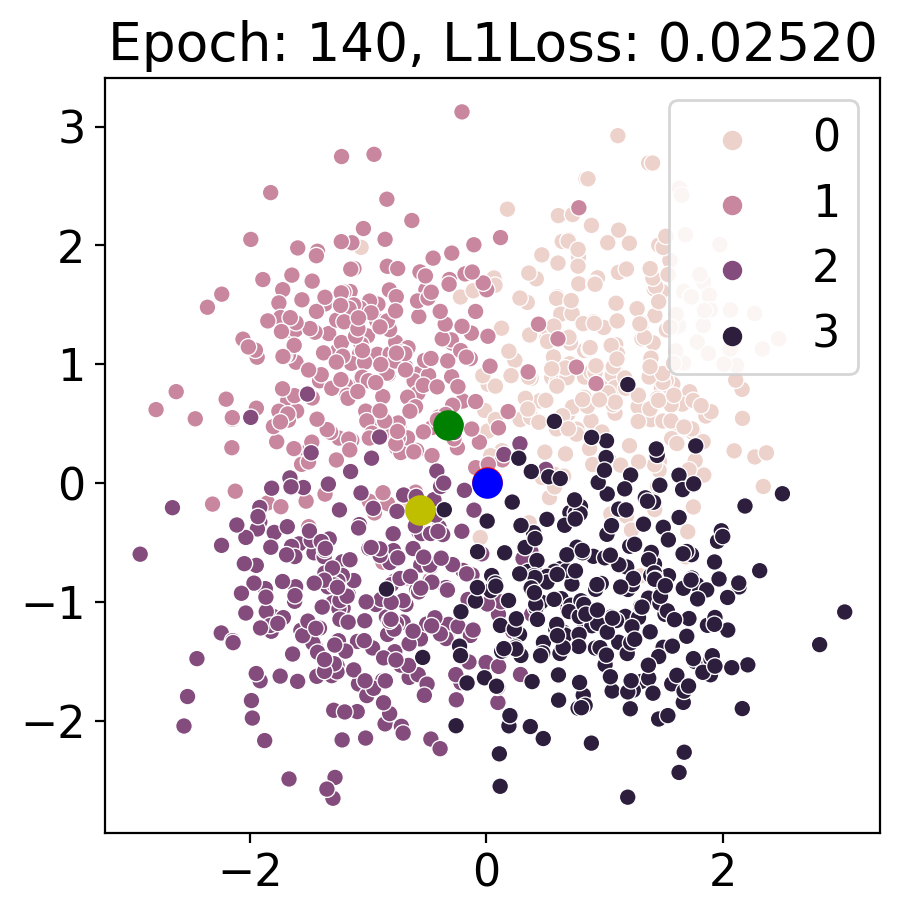

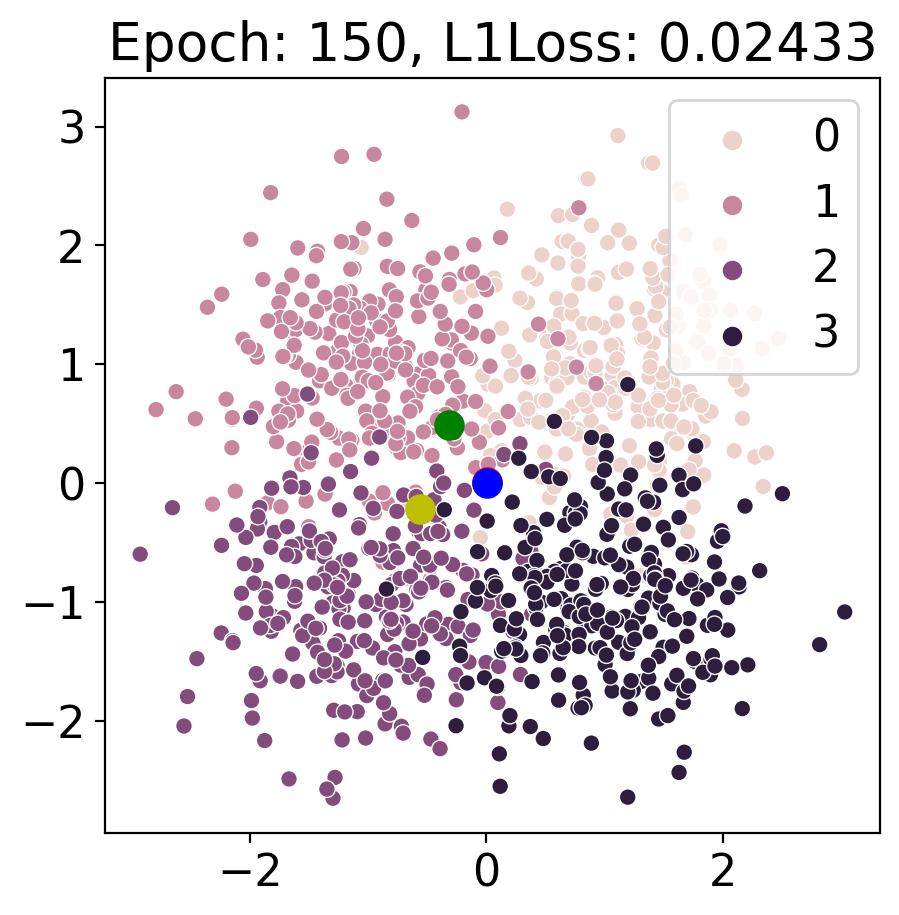

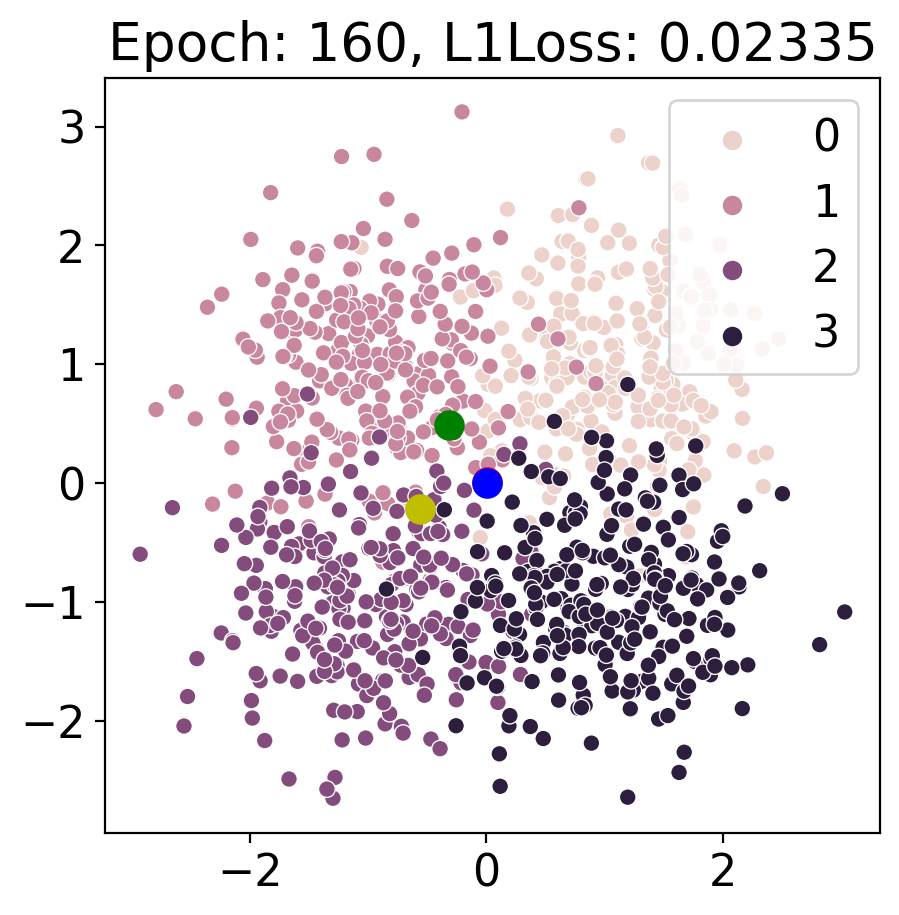

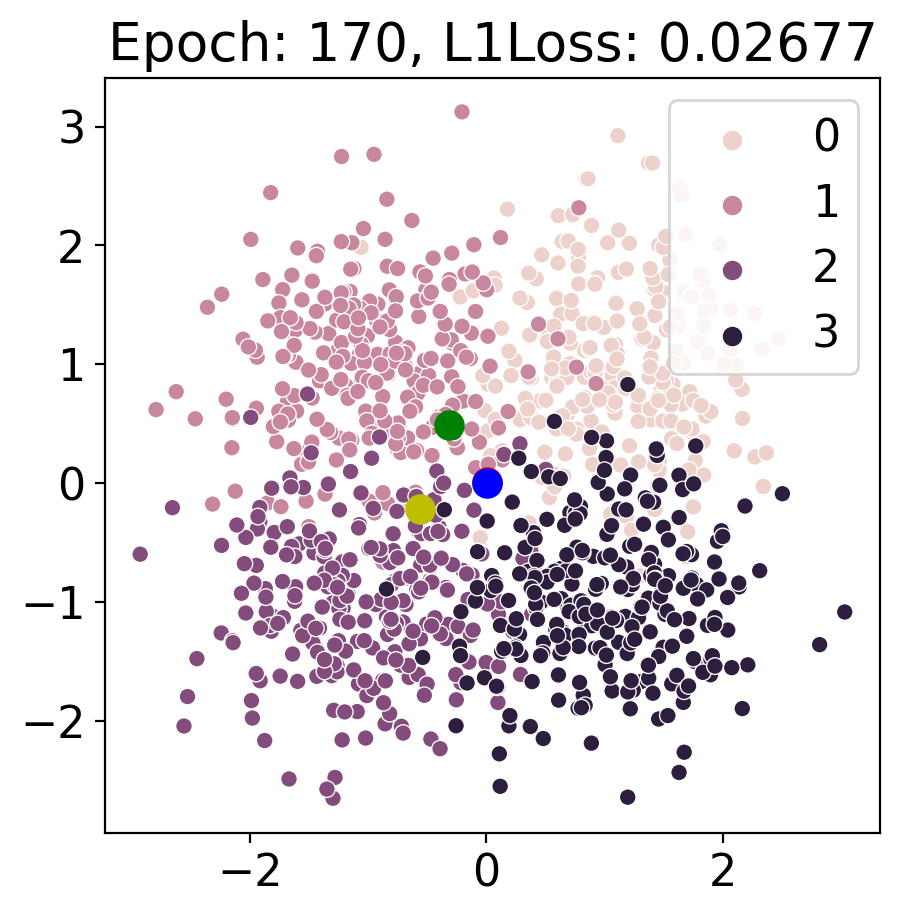

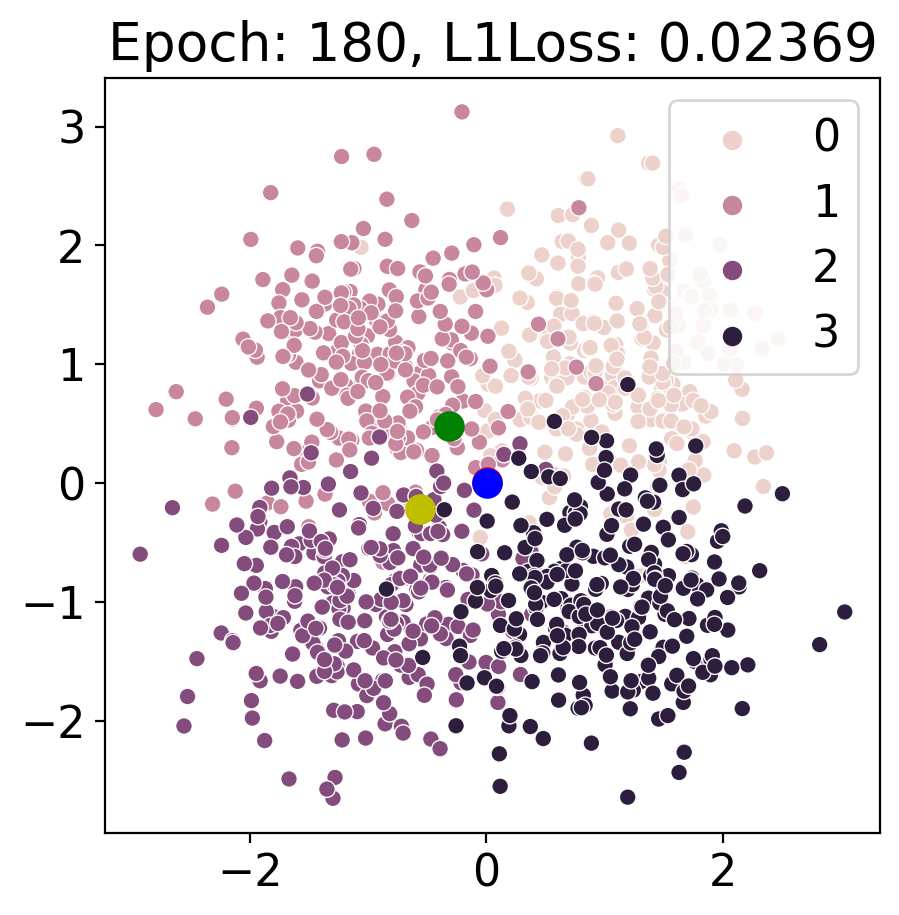

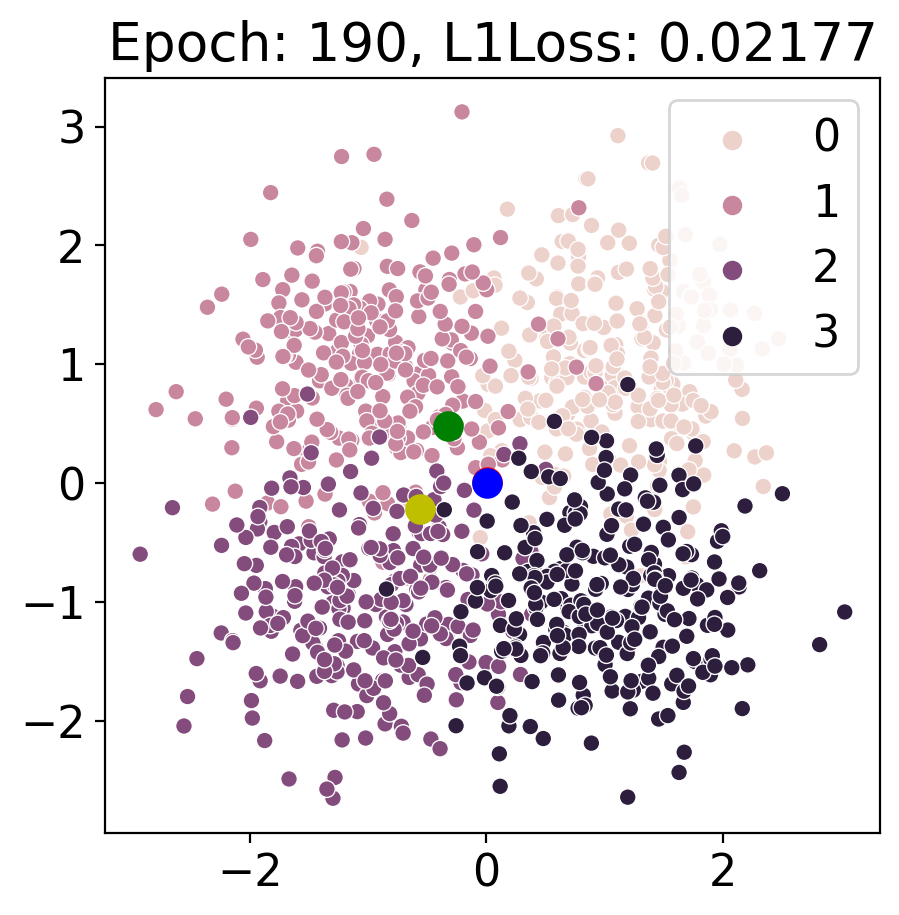

In [53]:
import torch
from dlquantification.attentionqnet import AttentionQNet
from dlquantification.utils.utils import APPBagGenerator
from dlquantification.featureextraction.nofe import NoFeatureExtractionModule
import matplotlib.pyplot as plt
import imageio.v3 as iio
import imageio
import seaborn as sns


dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train))
device = 'cpu'

attentionq = AttentionQNet(
    train_epochs=epochs,
    test_epochs=1,
    n_classes=4,
    start_lr=0.001,
    end_lr=0.000001,
    n_bags=100,
    bag_size=500,
    n_bins=n_bins,
    ind_points=ind_points,
    random_seed=2032,
    linear_sizes=[32],
    feature_extraction_module=NoFeatureExtractionModule(input_size=2),
    bag_generator=APPBagGenerator(device=device),
    val_bag_generator=APPBagGenerator(device=device),
    batch_size=1,
    quant_loss=torch.nn.L1Loss(),
    use_labels=False,
    device=device,
    verbose=1,
    dataset_name="test_synthetic",
)

images = []


def callback_epoch(val_total_loss, epoch):
    if epoch%10==0:
        ind_points=attentionq.model.quantmodule.I.cpu().detach().numpy()
        figure, ax = plt.subplots(figsize=(5, 5))
        ax.set_title("Epoch: %d, L1Loss: %.5f" % (epoch,val_total_loss))
        colors = ['g','r','b','y','c','m','k','w']
        ind_points = ind_points.squeeze()
        sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,ax=ax)
        for j in range(ind_points.shape[0]):
            plt.scatter(x=ind_points[j,0], y=ind_points[j,1], color=colors[j],s=100)
        
        figure.savefig('results/temp.png')
        images.append(iio.imread('results/temp.png'))
    

attentionq.callback_epoch = callback_epoch

attentionq.fit(dataset)
imageio.mimsave('results/movie.gif', images,fps=1)



In [54]:
import pandas as pd

testSampleGenerator = APPBagGenerator(device=device)
samples,prevalences = testSampleGenerator.compute_bags(n_bags=1000,bag_size=100,y=y_test)
results = pd.DataFrame(columns=("EMQ","AttentionQ"))
for sample,p in zip(samples,prevalences):
    sample_x = x_test[sample,:]
    p_hat=modelEMQ.best_model().quantify(sample_x)
    error_emq = torch.nn.functional.l1_loss(torch.FloatTensor(p_hat),torch.FloatTensor(p))
    p_hat=attentionq.predict(torch.utils.data.TensorDataset(torch.Tensor(sample_x)))
    error_attentionq = torch.nn.functional.l1_loss(torch.FloatTensor(p_hat),torch.FloatTensor(p))
    results.loc[len(results.index)] = [error_emq.numpy(),error_attentionq]

print(results.mean())

EMQ           0.017745
AttentionQ    0.032861
dtype: float64
